In [7]:
import sqlite3
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint


from sklearn.tree import export_graphviz
from IPython.display import Image
#import graphviz

In [11]:
con = sqlite3.connect("../unified_CD2.db")
cur = con.cursor()
#cur.execute("PRAGMA database_list;")
#cur.fetchall()

In [12]:
df = pd.read_sql_query("SELECT * FROM prod_desc", con)
df.head(3)


,index,id,name,AB,description,OX,source,seq,valid,MaxAbsEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.0,ADAM_2177,InverPep_ADAM_2177,b'\x01\x00\x00\x00\x00\x00\x00\x00',None,alien,InverPep.fasta,GLFNVFKGLKTAGKHVAGSLLNQLKCKVSGGC,yes,14.846797,...,0,0,0,0,0,0,0,0,5,0
1,NaN,P85444,PPIA_PENGL,b'\x00\x00\x00\x00\x00\x00\x00\x00',Peptidyl-prolyl cis-trans isomerase (Fragment),Penicillium glabrum OX=69773,uniprot_swissprot.fasta,KFADENFQLKH,yes,14.574620,...,0,0,0,0,0,0,0,0,2,0
2,NaN,P85445,ATPD_PENGL,b'\x00\x00\x00\x00\x00\x00\x00\x00',"ATP synthase subunit delta, mitochondrial (Fra...",Penicillium glabrum OX=69773 GN=atp16,uniprot_swissprot.fasta,KIANGSGSEQDIAEAKI,yes,14.109537,...,0,0,0,0,0,0,0,0,2,0


In [13]:
df['fr_term_acetylene'].unique()

array([0])

In [14]:
#reformatting AB to int
df['AB'] = df['AB'].apply(lambda x: int.from_bytes(x, 'little'))

In [15]:
# dropping unique descriptors
descriptors = df.columns[9:]
unidescriptors = [d for d in descriptors if len(df[d].unique()) < 2]
print('len desc, len unidesc', len(descriptors), len(unidescriptors))
print(df.shape)
df.drop(unidescriptors, axis = 1, inplace = True)
print(df.shape)


len desc, len unidesc 210 69
(12801, 219)
(12801, 150)


In [16]:
X = df.drop(['AB', 'index', 'id', 'name', 'valid', 'source', 'seq', 'description', 'OX'], axis = 1)
y = df['AB']
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)
X = X.clip(lower=-1e38, upper=1e38)
X_float = X.astype(np.float32)

#split into test and train

X_train, X_test, y_train, y_test = train_test_split(X_float, y, test_size = 0.30, random_state = 42)



In [17]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

rf = RandomForestClassifier(random_state = 1)

rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter = 5,
                                 cv = 5)

rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f96d7e6f3a0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f96d7e6ebf0>})

In [18]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)# from 19, 461


Best hyperparameters: {'max_depth': 17, 'n_estimators': 413}


In [20]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8200989325696433
Precision: 0.8335766423357664
Recall: 0.8307468477206595


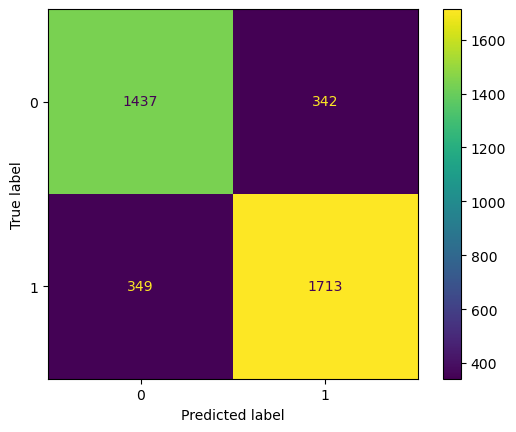

In [21]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

<AxesSubplot:>

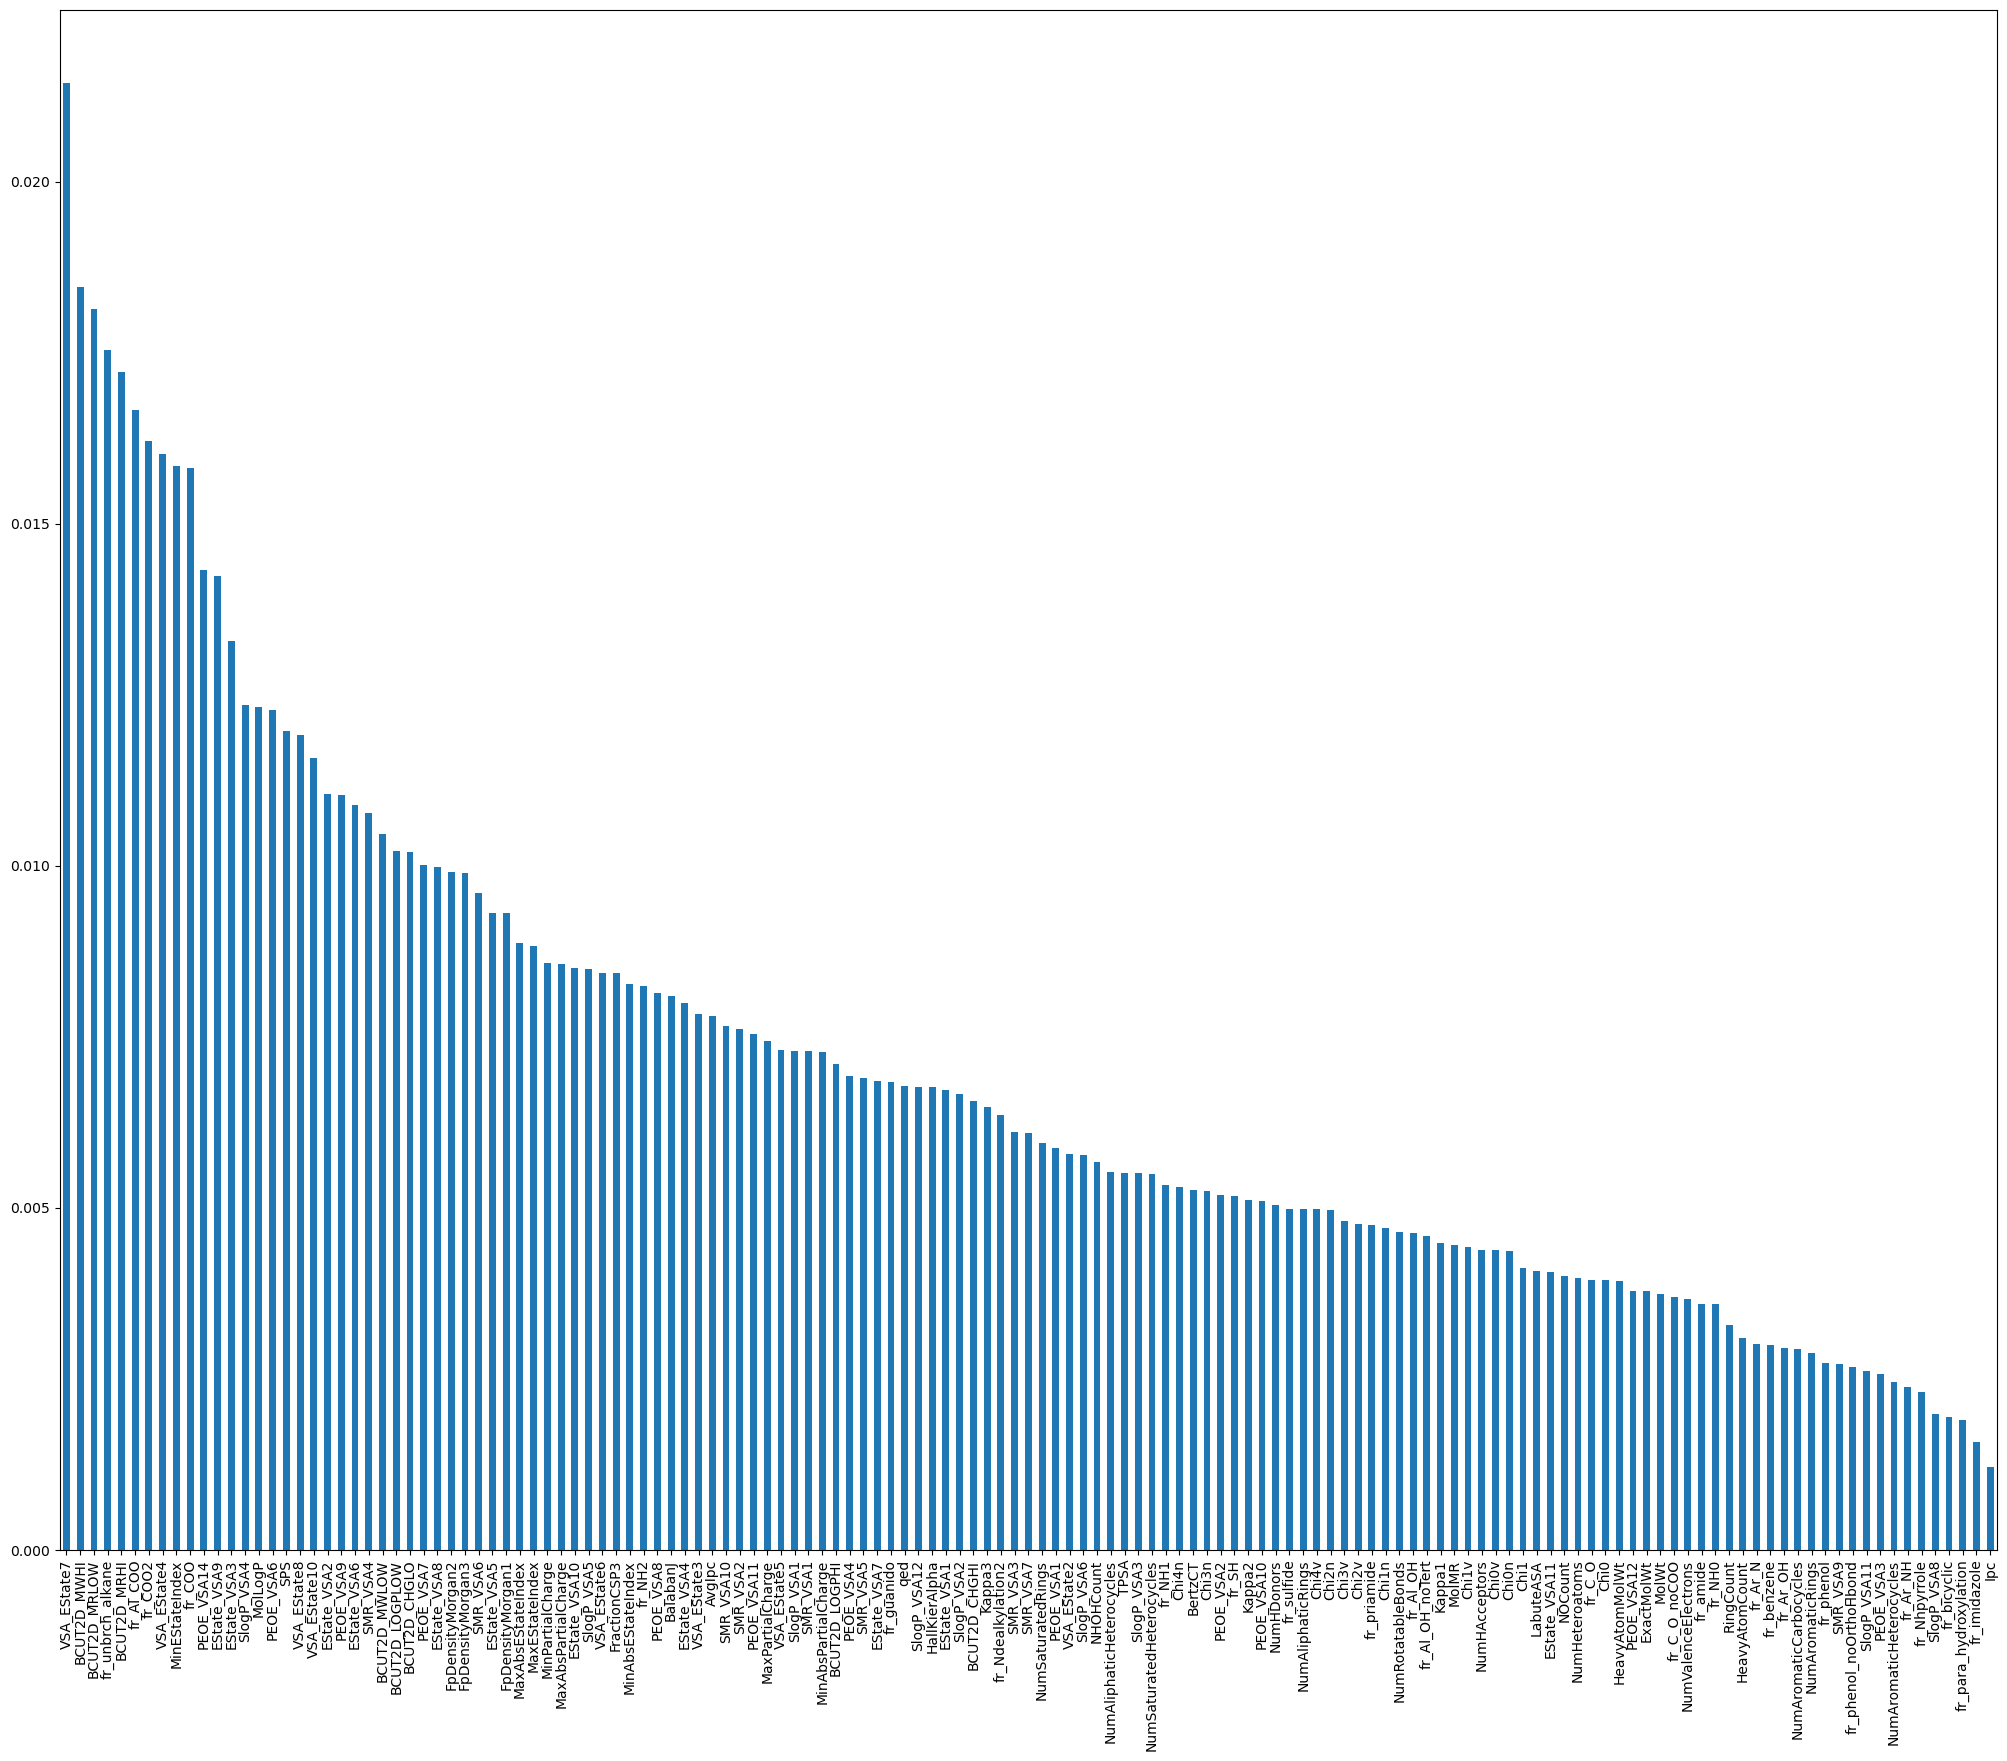

In [22]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar(width = 0.5, figsize =(25, 20))

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score 


y_pred_prob = best_rf.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

roc_auc = roc_auc_score(y_test, y_pred_prob) 
print('roc_auc: ', roc_auc)

roc_auc:  0.90517291670415


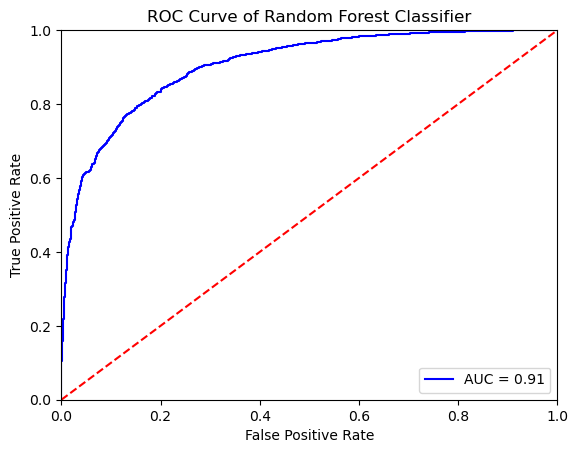

In [27]:

import matplotlib.pyplot as plt

plt.title('Receiver Operating Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Random Forest Classifier')
plt.show()